In [1]:
import os

from collections import OrderedDict

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import scipy

import warnings

from Standard_functions import plot_features, get_user_split_data, plot_fit_score_pred

warnings.filterwarnings('always') 
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [2]:
os.chdir('../Data/')

In [3]:
os.listdir()

['mini_feature_df',
 'mini_df',
 'products.csv',
 'orders.csv',
 '.DS_Store',
 '00_merged_prod_order',
 'mini_ord_prod_train_df',
 'order_products__train.csv',
 'departments.csv',
 'full_features_with_dep',
 'aisles.csv',
 'full_features',
 'mini_ord_df',
 'order_products__prior.csv',
 'no_feature_reduction',
 'sample_submission.csv']

## Loading our Datasets

In [4]:
df = pd.read_pickle('00_merged_prod_order')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474661 entries, 0 to 8474660
Data columns (total 5 columns):
product_id                   int64
user_id                      int64
num_ord_per_user_per_prod    int64
latest_cart                  object
in_cart                      int64
dtypes: int64(4), object(1)
memory usage: 387.9+ MB


In [6]:
ord_prod_test_df = pd.read_csv('order_products__train.csv')
ord_df = pd.read_csv('orders.csv')
ord_prod_test_df = ord_prod_test_df.merge(ord_df, on='order_id')
prod_df = pd.read_csv('products.csv')
dep_df = pd.read_csv('departments.csv')

In [7]:
df.user_id.nunique()

131209

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474661 entries, 0 to 8474660
Data columns (total 5 columns):
product_id                   int64
user_id                      int64
num_ord_per_user_per_prod    int64
latest_cart                  object
in_cart                      int64
dtypes: int64(4), object(1)
memory usage: 387.9+ MB


## Feature Engineering

Our feature engineering began in the 'Organizing data section.  
We will visualize that first feature below and begin creating new features.

<Figure size 648x648 with 0 Axes>

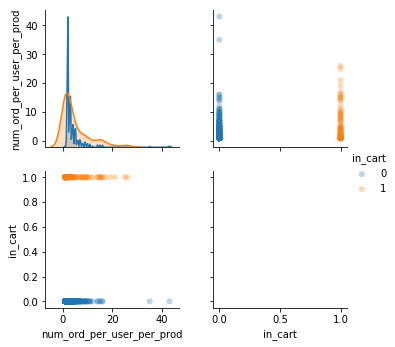

Our f1-score is 0.0864409013045197
The coefficients are: 
                     Features  Coefficients
0  num_ord_per_user_per_prod        0.1422
And we've predicted 1675585 non-re-orders and 16723 re-orders.


In [9]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

As you can see, we're setting the bar pretty low.

## Product Features
Note that product features are not user-specific.

### `product_total_orders`
Total number of orders placed for a given product.
### `product_avg_add_to_cart_order`
Average order in which a product was add to a users cart.

In [10]:
prod_features = ['product_total_orders','product_avg_add_to_cart_order']

df_prod_features = (ord_prod_train_df.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
df_prod_features.columns = ['product_id'] + prod_features
df = df.merge(df_prod_features, on='product_id')

`product_total_orders` had some pretty enourmous rightward skew that ultimately resulted in the model producing 0 positive predictions. As a result I took the log base 2 transformation to punish outliers.  
Note that I attempted a log base 10 transformation but log base 2 had better results.

In [11]:
df.product_total_orders = np.log2(df.product_total_orders)

<Figure size 648x648 with 0 Axes>

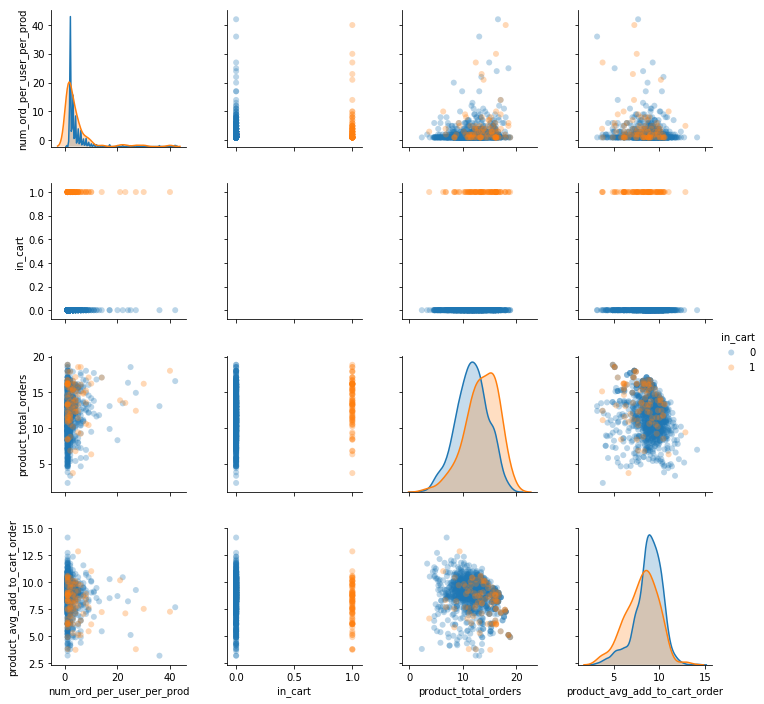

Our f1-score is 0.08767651253688119
The coefficients are: 
                         Features  Coefficients
0      num_ord_per_user_per_prod        0.1230
1           product_total_orders        0.0795
2  product_avg_add_to_cart_order       -0.1667
And we've predicted 1679289 non-re-orders and 16445 re-orders.


In [12]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## User Features
`'user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order'`

In [13]:
user_features = ['user_total_orders','user_avg_cartsize',
                 'user_total_products','user_avg_days_since_prior_order']

df_user_features = (ord_prod_train_df.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                       [('order_id',
                         ['nunique', # user_total_orders
                        (lambda x: x.shape[0] / x.nunique())]), # user_avg_cartsize
                        ('product_id','nunique'), # user_total_products
                        ('days_since_prior_order','mean')]))) # user_avg_days_since_prior_order
df_user_features.columns = ['user_id'] + user_features
df = df.merge(df_user_features, on='user_id')

<Figure size 648x648 with 0 Axes>

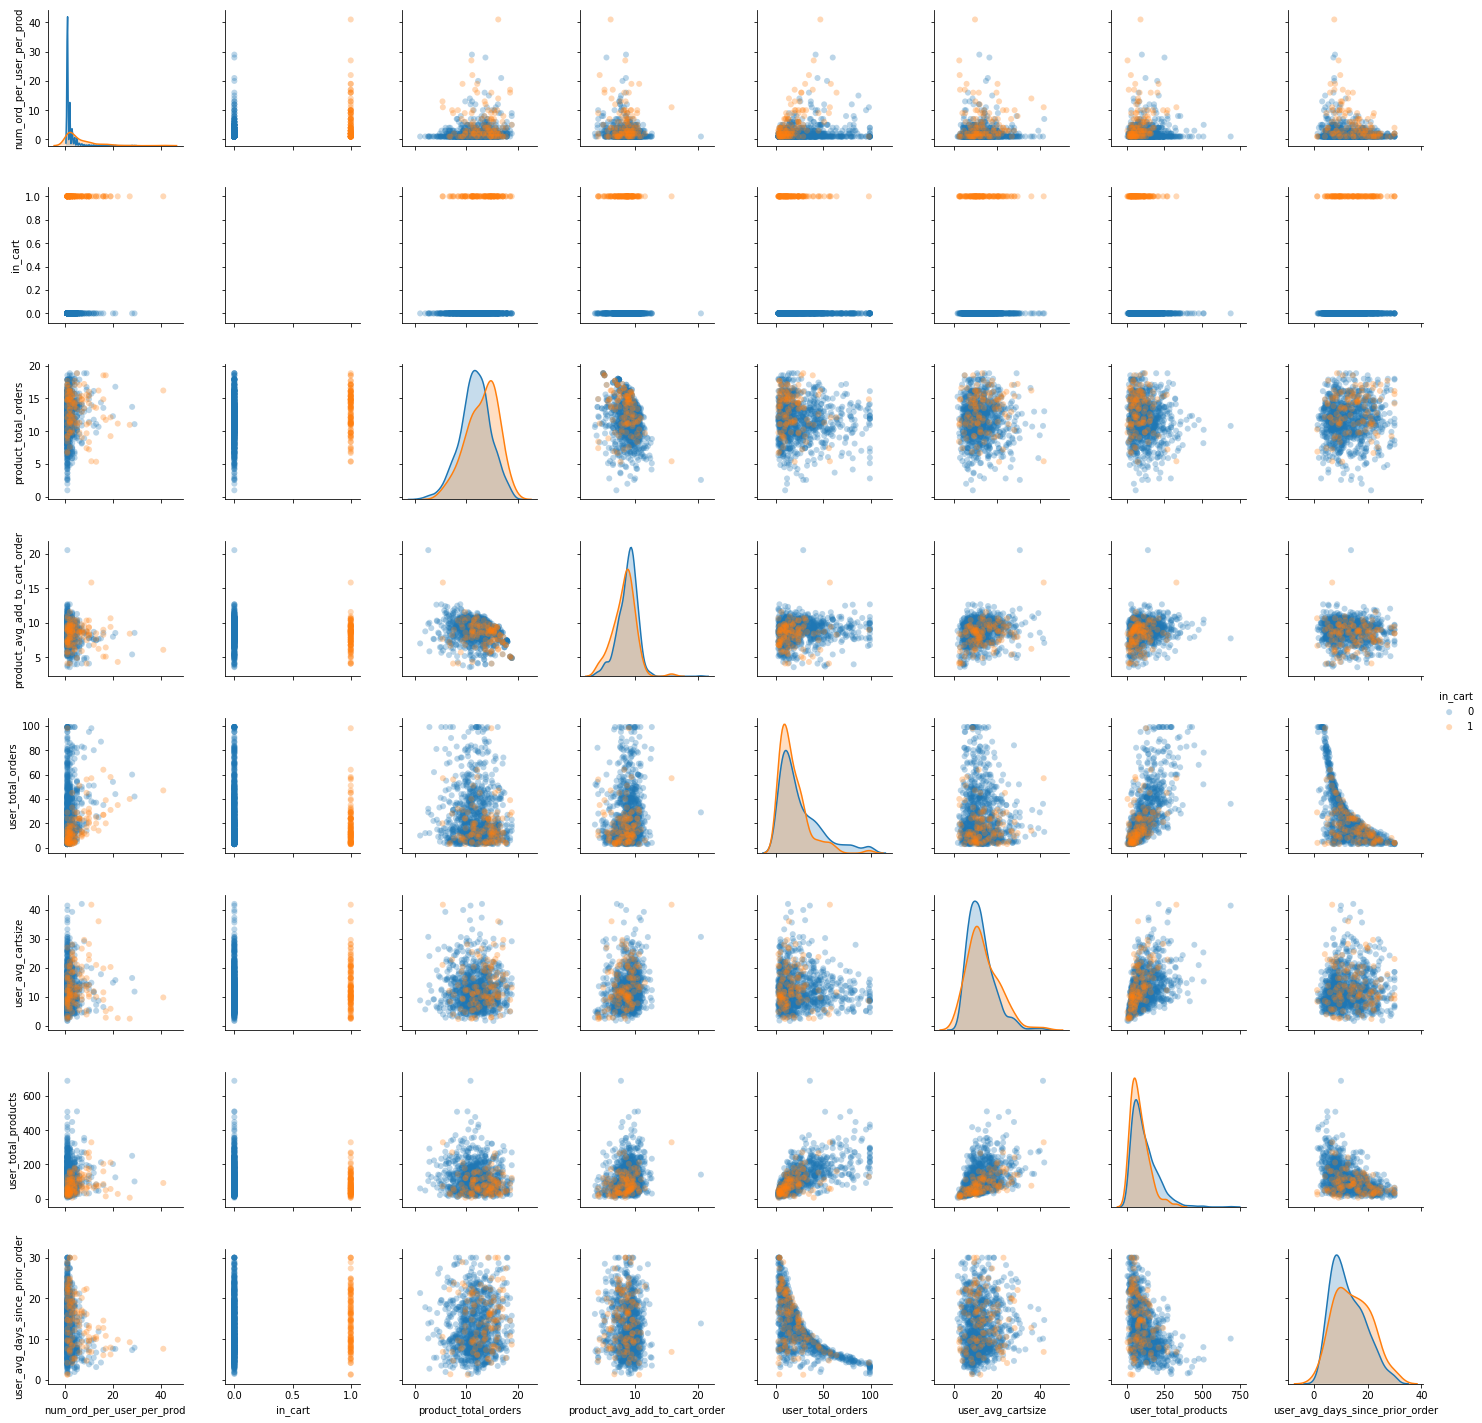

Our f1-score is 0.12110314302130103
The coefficients are: 
                           Features  Coefficients
0        num_ord_per_user_per_prod        0.1809
1             product_total_orders        0.0726
2    product_avg_add_to_cart_order       -0.1338
3                user_total_orders       -0.0231
4                user_avg_cartsize        0.0447
5              user_total_products       -0.0054
6  user_avg_days_since_prior_order       -0.0016
And we've predicted 1675015 non-re-orders and 20719 re-orders.


In [14]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## User-Product features

In [15]:
user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (ord_prod_train_df.groupby(
                        ['product_id','user_id'],as_index=False) \
                        .agg(OrderedDict(
                        [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 
df = df.merge(df_user_prod_features,on=['user_id','product_id'])
df['user_product_order_freq'] = df['num_ord_per_user_per_prod'] / df['user_total_orders'] 

<Figure size 648x648 with 0 Axes>

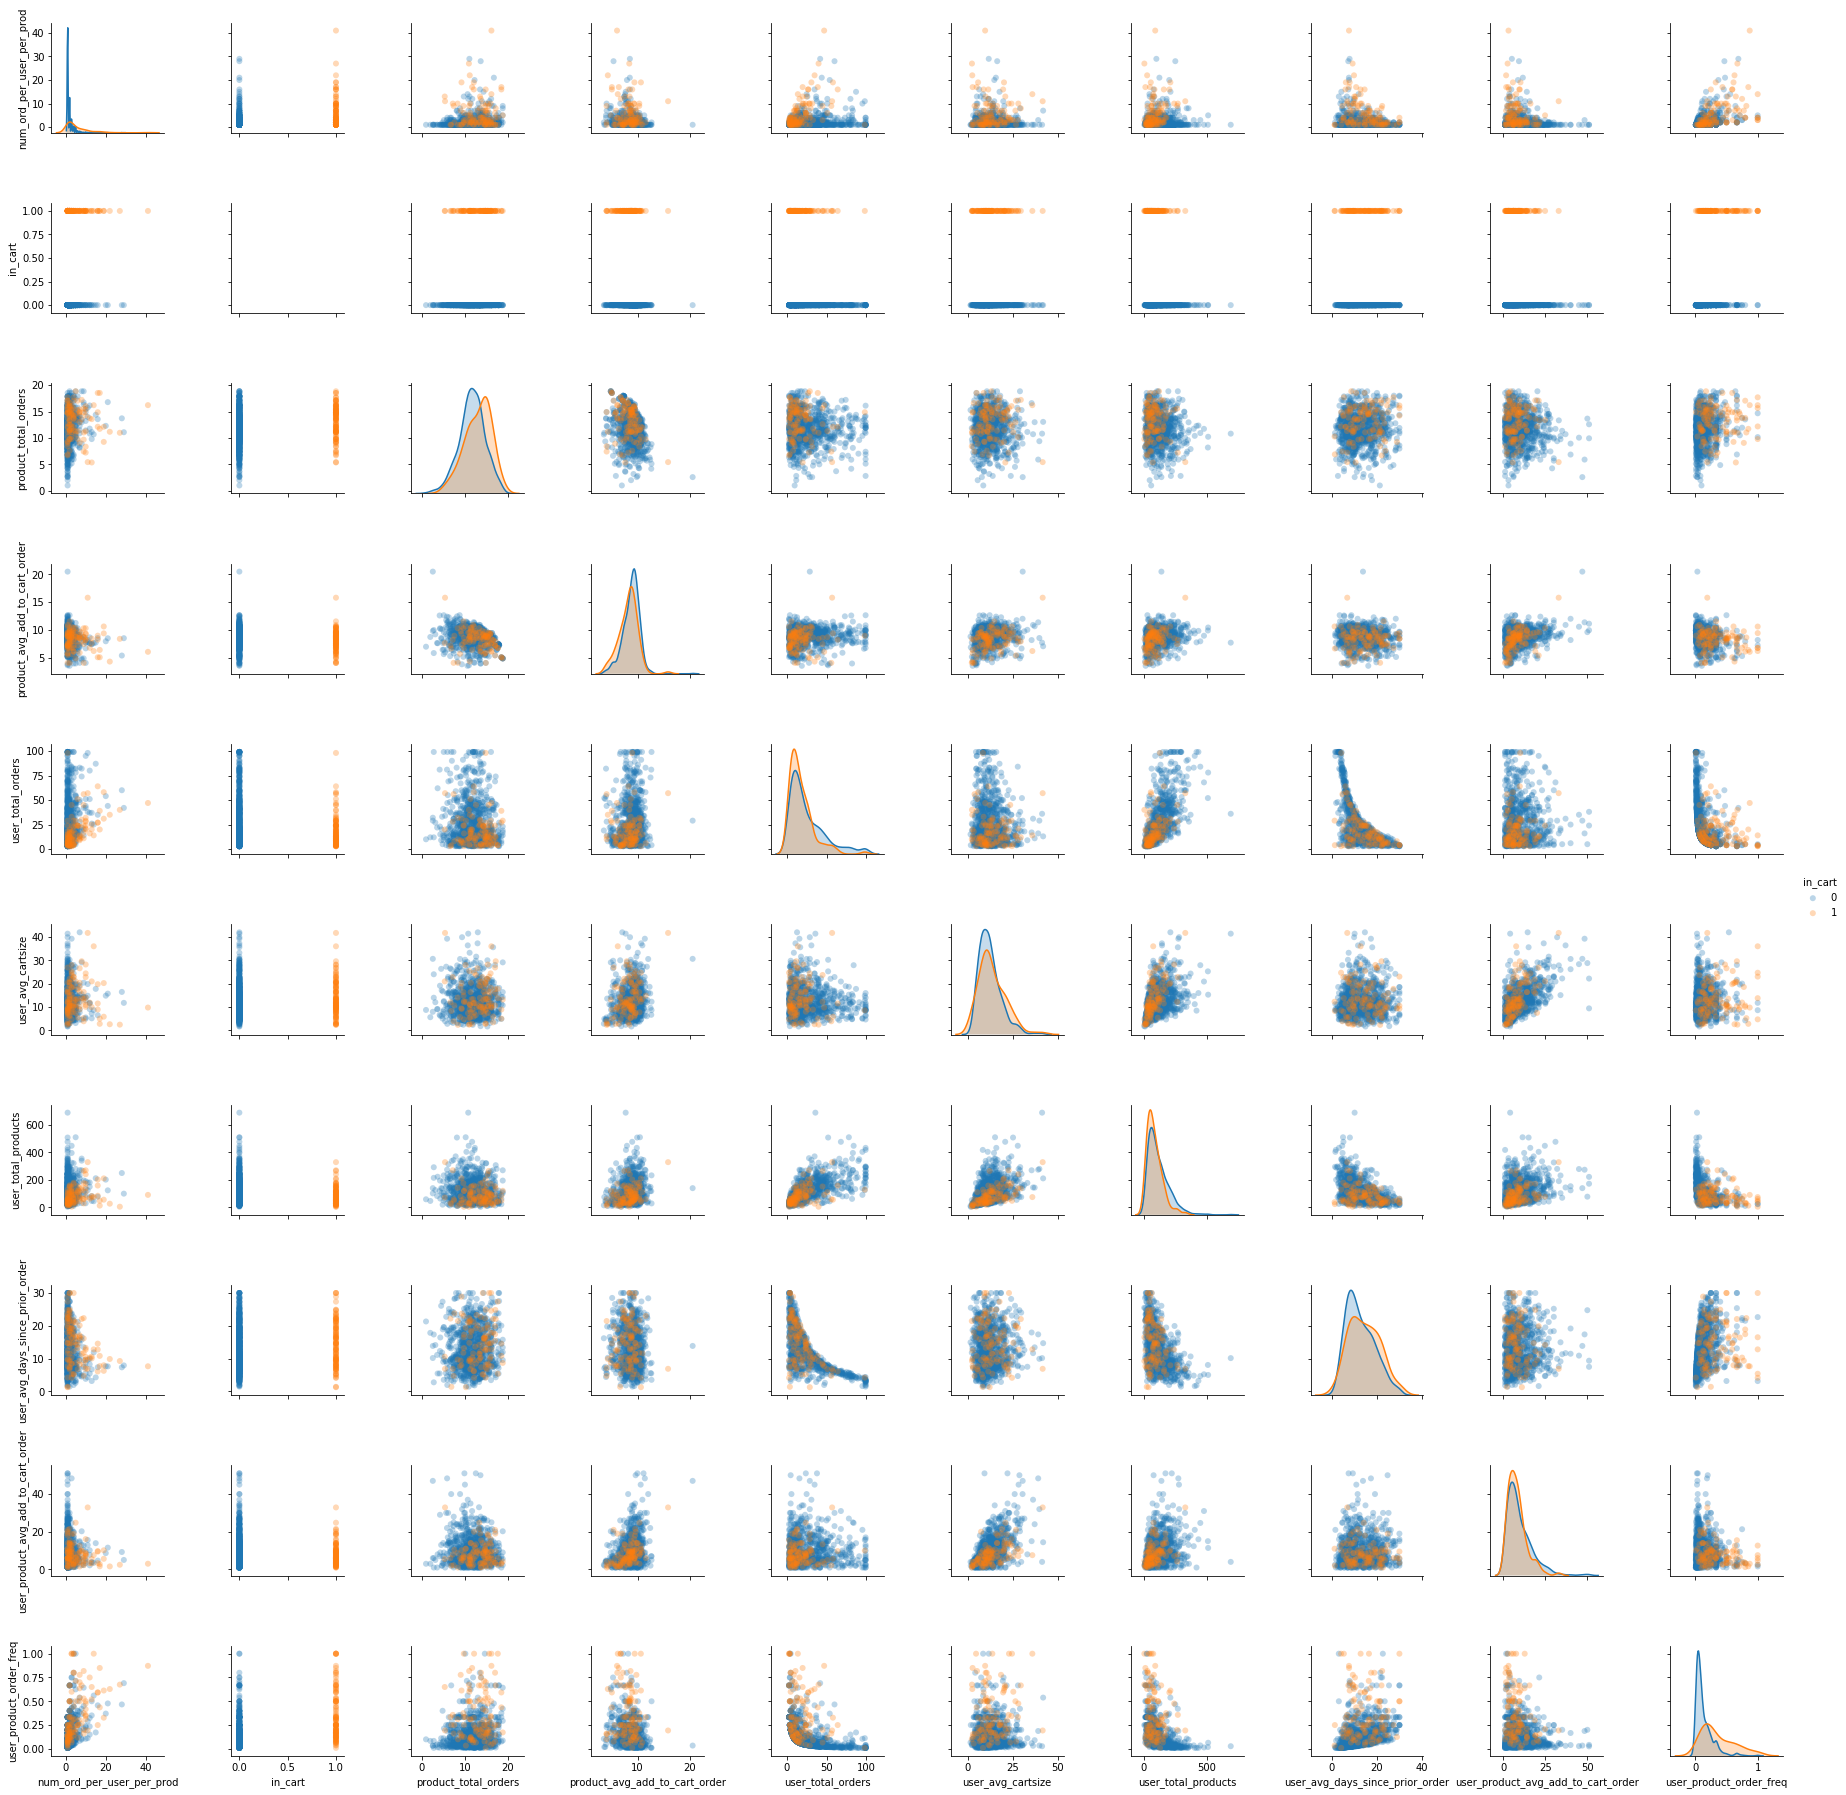

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Our f1-score is 0.22880326889347186
The coefficients are: 
                              Features  Coefficients
0           num_ord_per_user_per_prod        0.0601
1                product_total_orders        0.0339
2       product_avg_add_to_cart_order       -0.1371
3                   user_total_orders       -0.0081
4                   user_avg_cartsize        0.0142
5                 user_total_products       -0.0016
6     user_avg_days_since_prior_order       -0.0180
7  user_product_avg_add_to_cart_order        0.0015
8             user_product_order_freq        3.6194
And we've predicted 1655455 non-re-orders and 40279 re-orders.


In [16]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## Users Orders Features
mean, min, and max of order hour of day by user all proved to be poor predictors.

``` python
orders_features = ['mean_order_hour_of_day_by_user','min_order_hour_of_day_by_user',
                 'max_order_hour_of_day_by_user']

df_orders_features = (ord_df.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                       [('order_hour_of_day',
                         ['mean', 'min', 'max'])]))) # user_avg_days_since_prior_order
df_orders_features.columns = ['user_id'] + orders_features
df = df.merge(df_orders_features, on='user_id')
```

Further grouping of the above by product provided no additional insight.

``` python 
avg_order_hour_by_user_by_product = (ord_prod_train_df
                             .dropna().groupby(['user_id','product_id']
                                ,as_index=False).order_hour_of_day.mean())

avg_order_hour_by_user_by_product.columns = ['user_id','product_id','avg_order_hour_by_user_by_product'] 
df = pd.merge(df, avg_order_hour_by_user_by_product,on=['user_id','product_id'])
```

## Count of Orders by Day of Week

``` python 
dummies = pd.get_dummies(ord_df.order_dow)
df_dummies = pd.merge(ord_df,dummies,how='outer',left_index=True,right_index=True)
total_orders_by_dow = (df_dummies.groupby('user_id',as_index=False)
                  .sum().drop(['order_number','order_dow','order_hour_of_day',
                              'days_since_prior_order'],axis=1))
total_orders_by_dow.columns = (['user_id','order_id'] + 
                    ['total_orders_day ' + str(x) for x in range(0,7)])
df = pd.merge(df, total_orders_by_dow,on=['user_id'])
```

## Mode Hour and DOW Ordered

``` python
product_mode_hour_ordered = (ord_prod_train_df.groupby('product_id',
                              as_index=False).order_hour_of_day
                             .agg(lambda x:x.value_counts().index[0]))
product_mode_hour_ordered.columns = ['product_id','product_mode_hour_ordered']
df = pd.merge(df, product_mode_hour_ordered,on=['product_id'])
```

``` python 
product_mode_dow_ordered = (ord_prod_train_df.groupby('product_id',
                              as_index=False).order_dow
                             .agg(lambda x:x.value_counts().index[0]))
product_mode_dow_ordered.columns = ['product_id','product_mode_dow_ordered']
df = pd.merge(df, product_mode_dow_ordered,on=['product_id'])
```

In [17]:
#pd.to_pickle(df,'mini_feature_df')

## Number of Orders Placed Since a Product was Last Ordered
## Percentage of Orders Containing a Product

In [18]:
new_feats = ['total_orders_containig_product','most_recent_order_by_user_by_product']

most_recent_order_by_user_by_product = (ord_prod_train_df.groupby(['user_id','product_id'],
                                                        as_index=False).agg(OrderedDict(
                                                        [('reordered','sum'),
                                                        ('order_number','max')])))
most_recent_order_by_user_by_product.columns = ['user_id','product_id'] + new_feats

max_orders_per_user = ord_prod_train_df.groupby(['user_id'],as_index=False).order_number.max()
max_orders_per_user.columns = ['user_id'] + ['number_orders_since_product_last_ordered']

number_orders_since_product_last_ordered = pd.merge(most_recent_order_by_user_by_product, 
                                                    max_orders_per_user,on='user_id')

number_orders_since_product_last_ordered['percent_of_time_product_ordered'] =(
    number_orders_since_product_last_ordered['total_orders_containig_product'] / 
    number_orders_since_product_last_ordered['number_orders_since_product_last_ordered'])
    # Note that we use the column name `number_orders_since_product_last_ordered` as that
    # is currently set to the max max order and does not yet actually contain the 
    # number of orders since a product was last ordered.

percent_of_time_product_ordered = number_orders_since_product_last_ordered[['percent_of_time_product_ordered',
                                                                      'user_id','product_id']]

number_orders_since_product_last_ordered = (number_orders_since_product_last_ordered[
                    ['most_recent_order_by_user_by_product','number_orders_since_product_last_ordered']]
                    .diff(axis=1).drop('most_recent_order_by_user_by_product',axis=1))

most_recent_order_by_user_by_product.drop('most_recent_order_by_user_by_product',
                                          axis=1,inplace=True) # we're just using this to get back our product_id and user_id
number_orders_since_product_last_ordered = pd.merge(number_orders_since_product_last_ordered,most_recent_order_by_user_by_product,
                        left_index=True,right_index=True)

combined_feats = pd.merge(number_orders_since_product_last_ordered,percent_of_time_product_ordered,
                        on=['user_id','product_id'])

combined_feats.drop('total_orders_containig_product',axis=1,inplace=True)

df = pd.merge(df, combined_feats,on=['user_id','product_id'])

<Figure size 648x648 with 0 Axes>

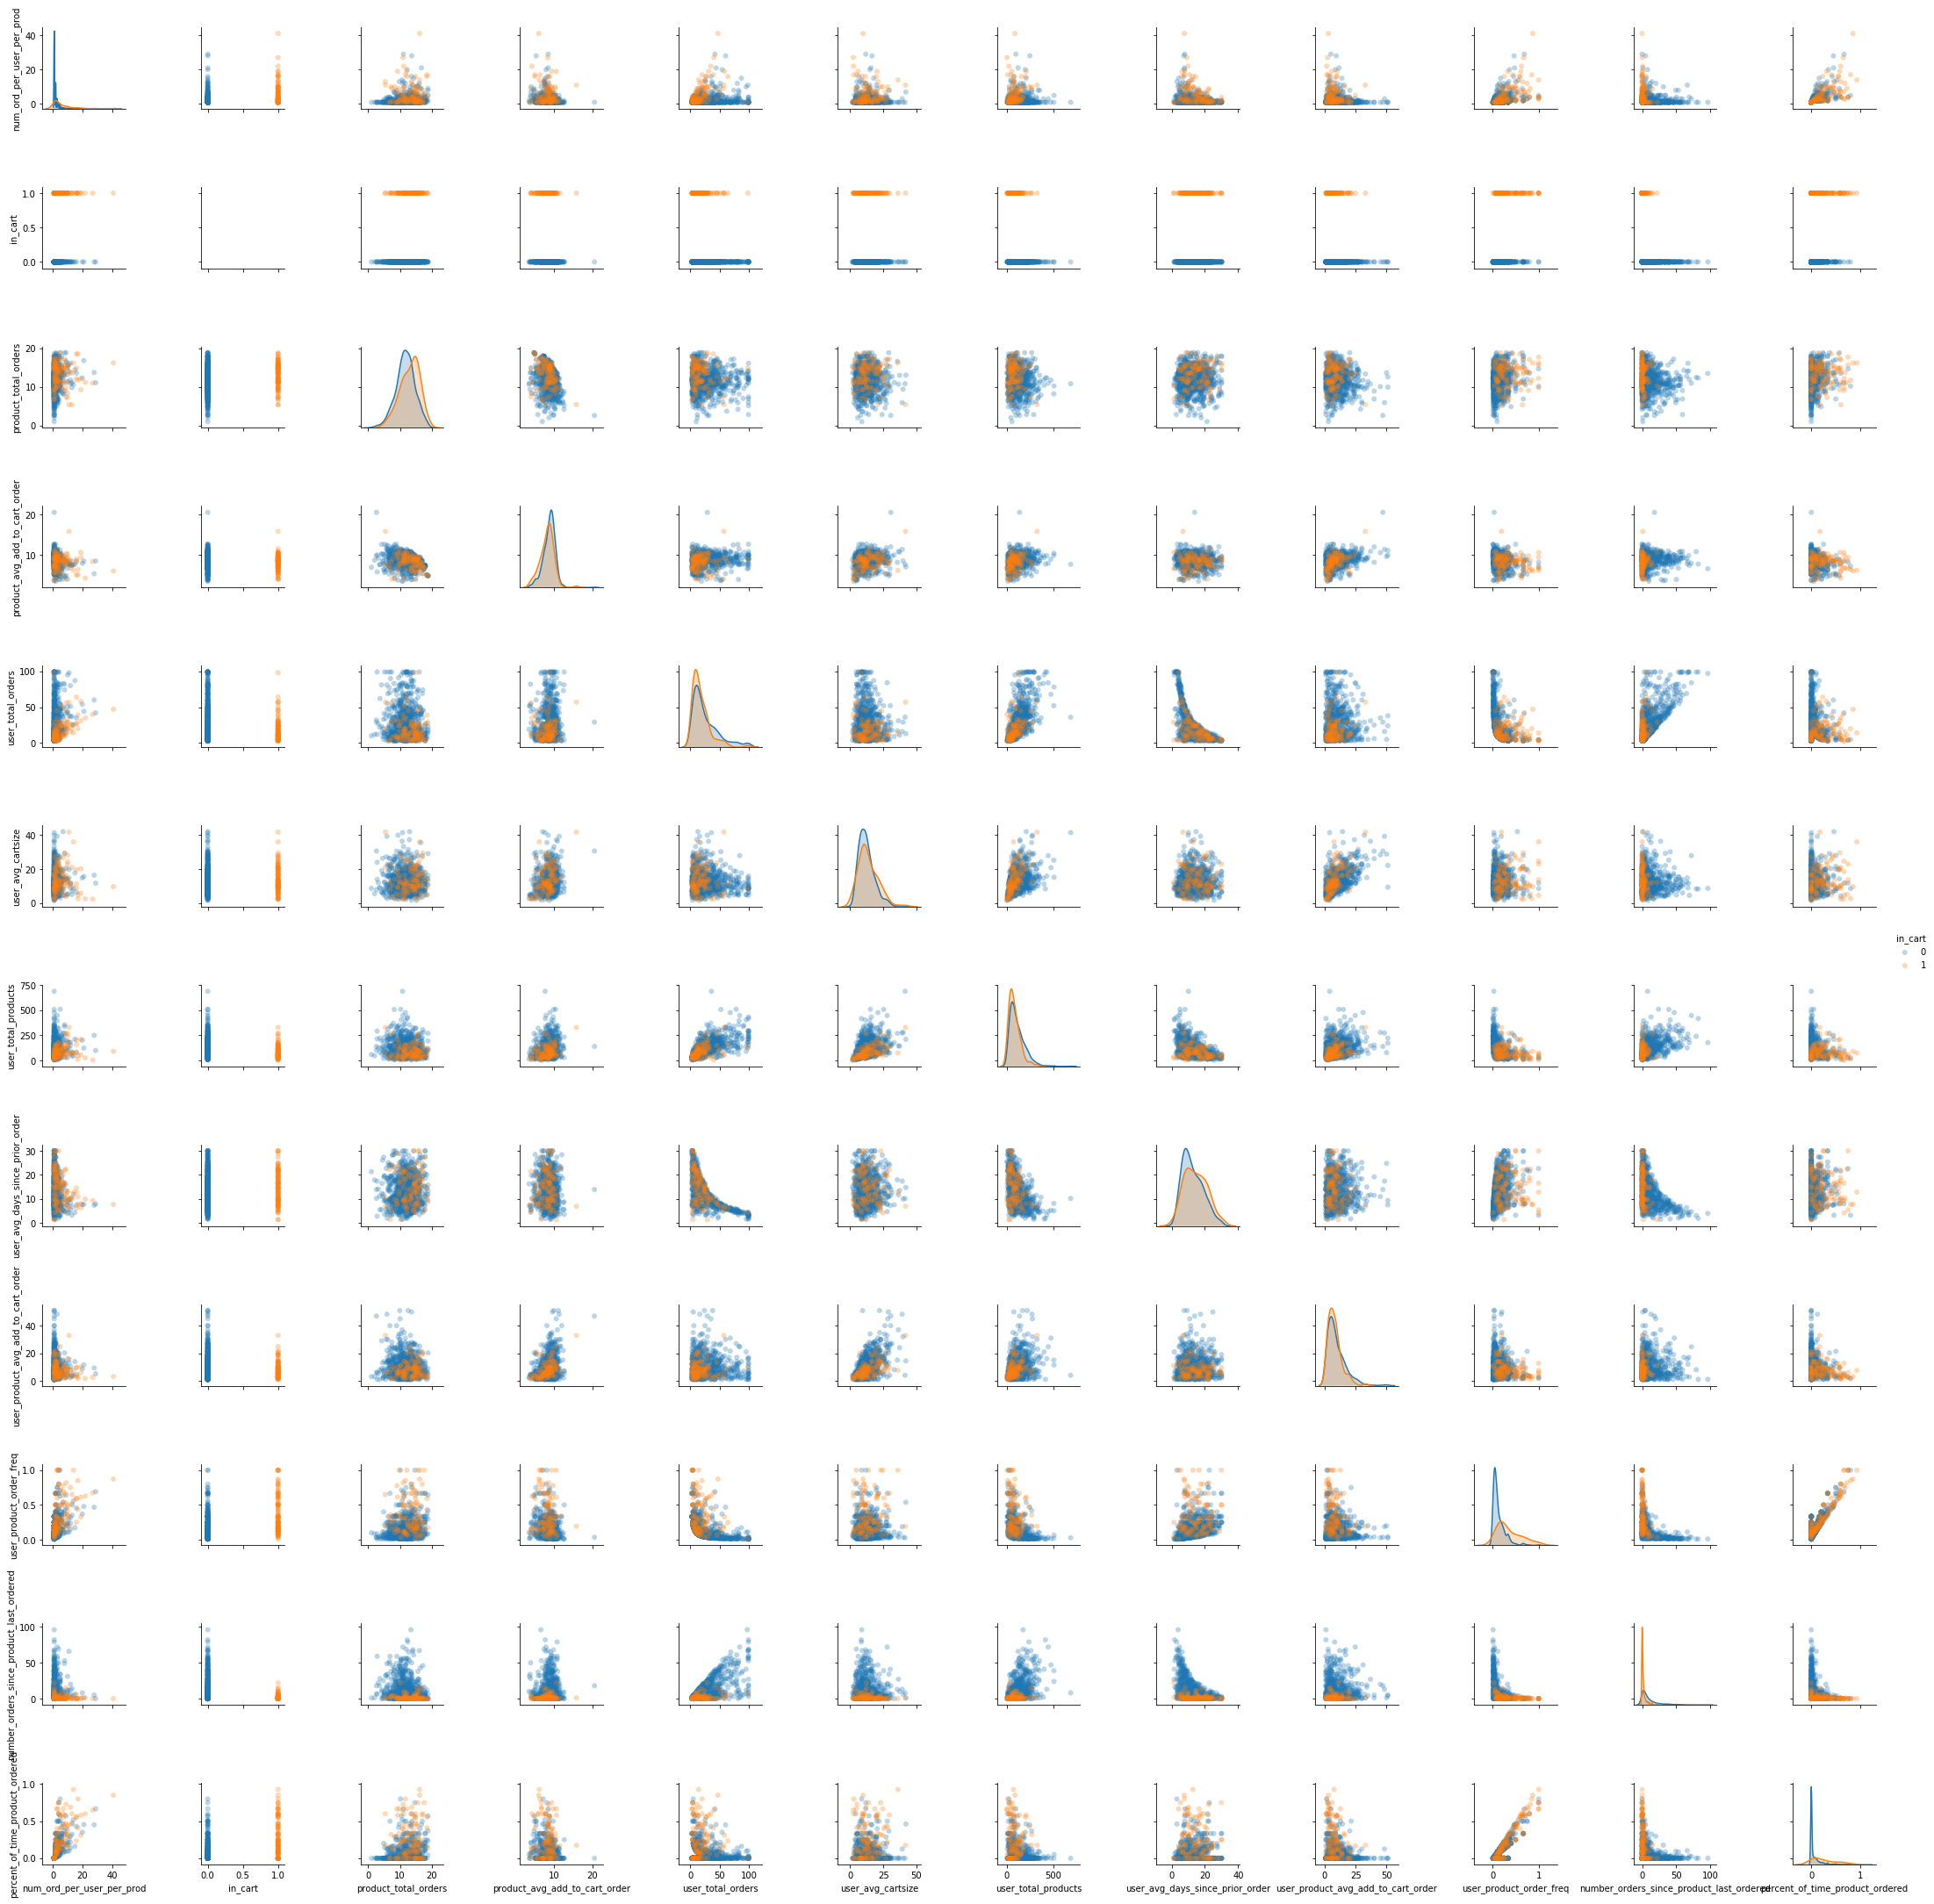

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Our f1-score is 0.2505191875715208
The coefficients are: 
                                     Features  Coefficients
0                  num_ord_per_user_per_prod        0.0048
1                       product_total_orders        0.0169
2              product_avg_add_to_cart_order       -0.1931
3                          user_total_orders        0.0089
4                          user_avg_cartsize        0.0237
5                        user_total_products       -0.0018
6            user_avg_days_since_prior_order       -0.0174
7         user_product_avg_add_to_cart_order       -0.0036
8                    user_product_order_freq        1.7291
9   number_orders_since_product_last_ordered       -0.1261
10           percent_of_time_product_ordered        1.9106
And we've predicted 1650636 non-re-orders and 45098 re-orders.


In [19]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## Time since most recent order by user

In [20]:
mean_hod = (ord_df.groupby(['user_id'],as_index=False)
                    .agg({'order_hour_of_day':'mean'}))
mean_hod.columns = ['user_id','mean_order_hour_of_day_by_user']

most_recent_order_time = (ord_df.groupby(['user_id'],as_index=False)
                    .agg({'order_number':'max'}))
temp = pd.merge(most_recent_order_time,ord_df, on=['user_id','order_number'],how='left')
temp = pd.merge(temp[['user_id','order_hour_of_day']], mean_hod, on=['user_id'])
temp['diff_between_average_and_current_order_time'] = (temp['order_hour_of_day'] - 
                                        temp['mean_order_hour_of_day_by_user'])
df = pd.merge(df, temp.drop('order_hour_of_day',axis=1)
              ,on=['user_id'])

<Figure size 648x648 with 0 Axes>

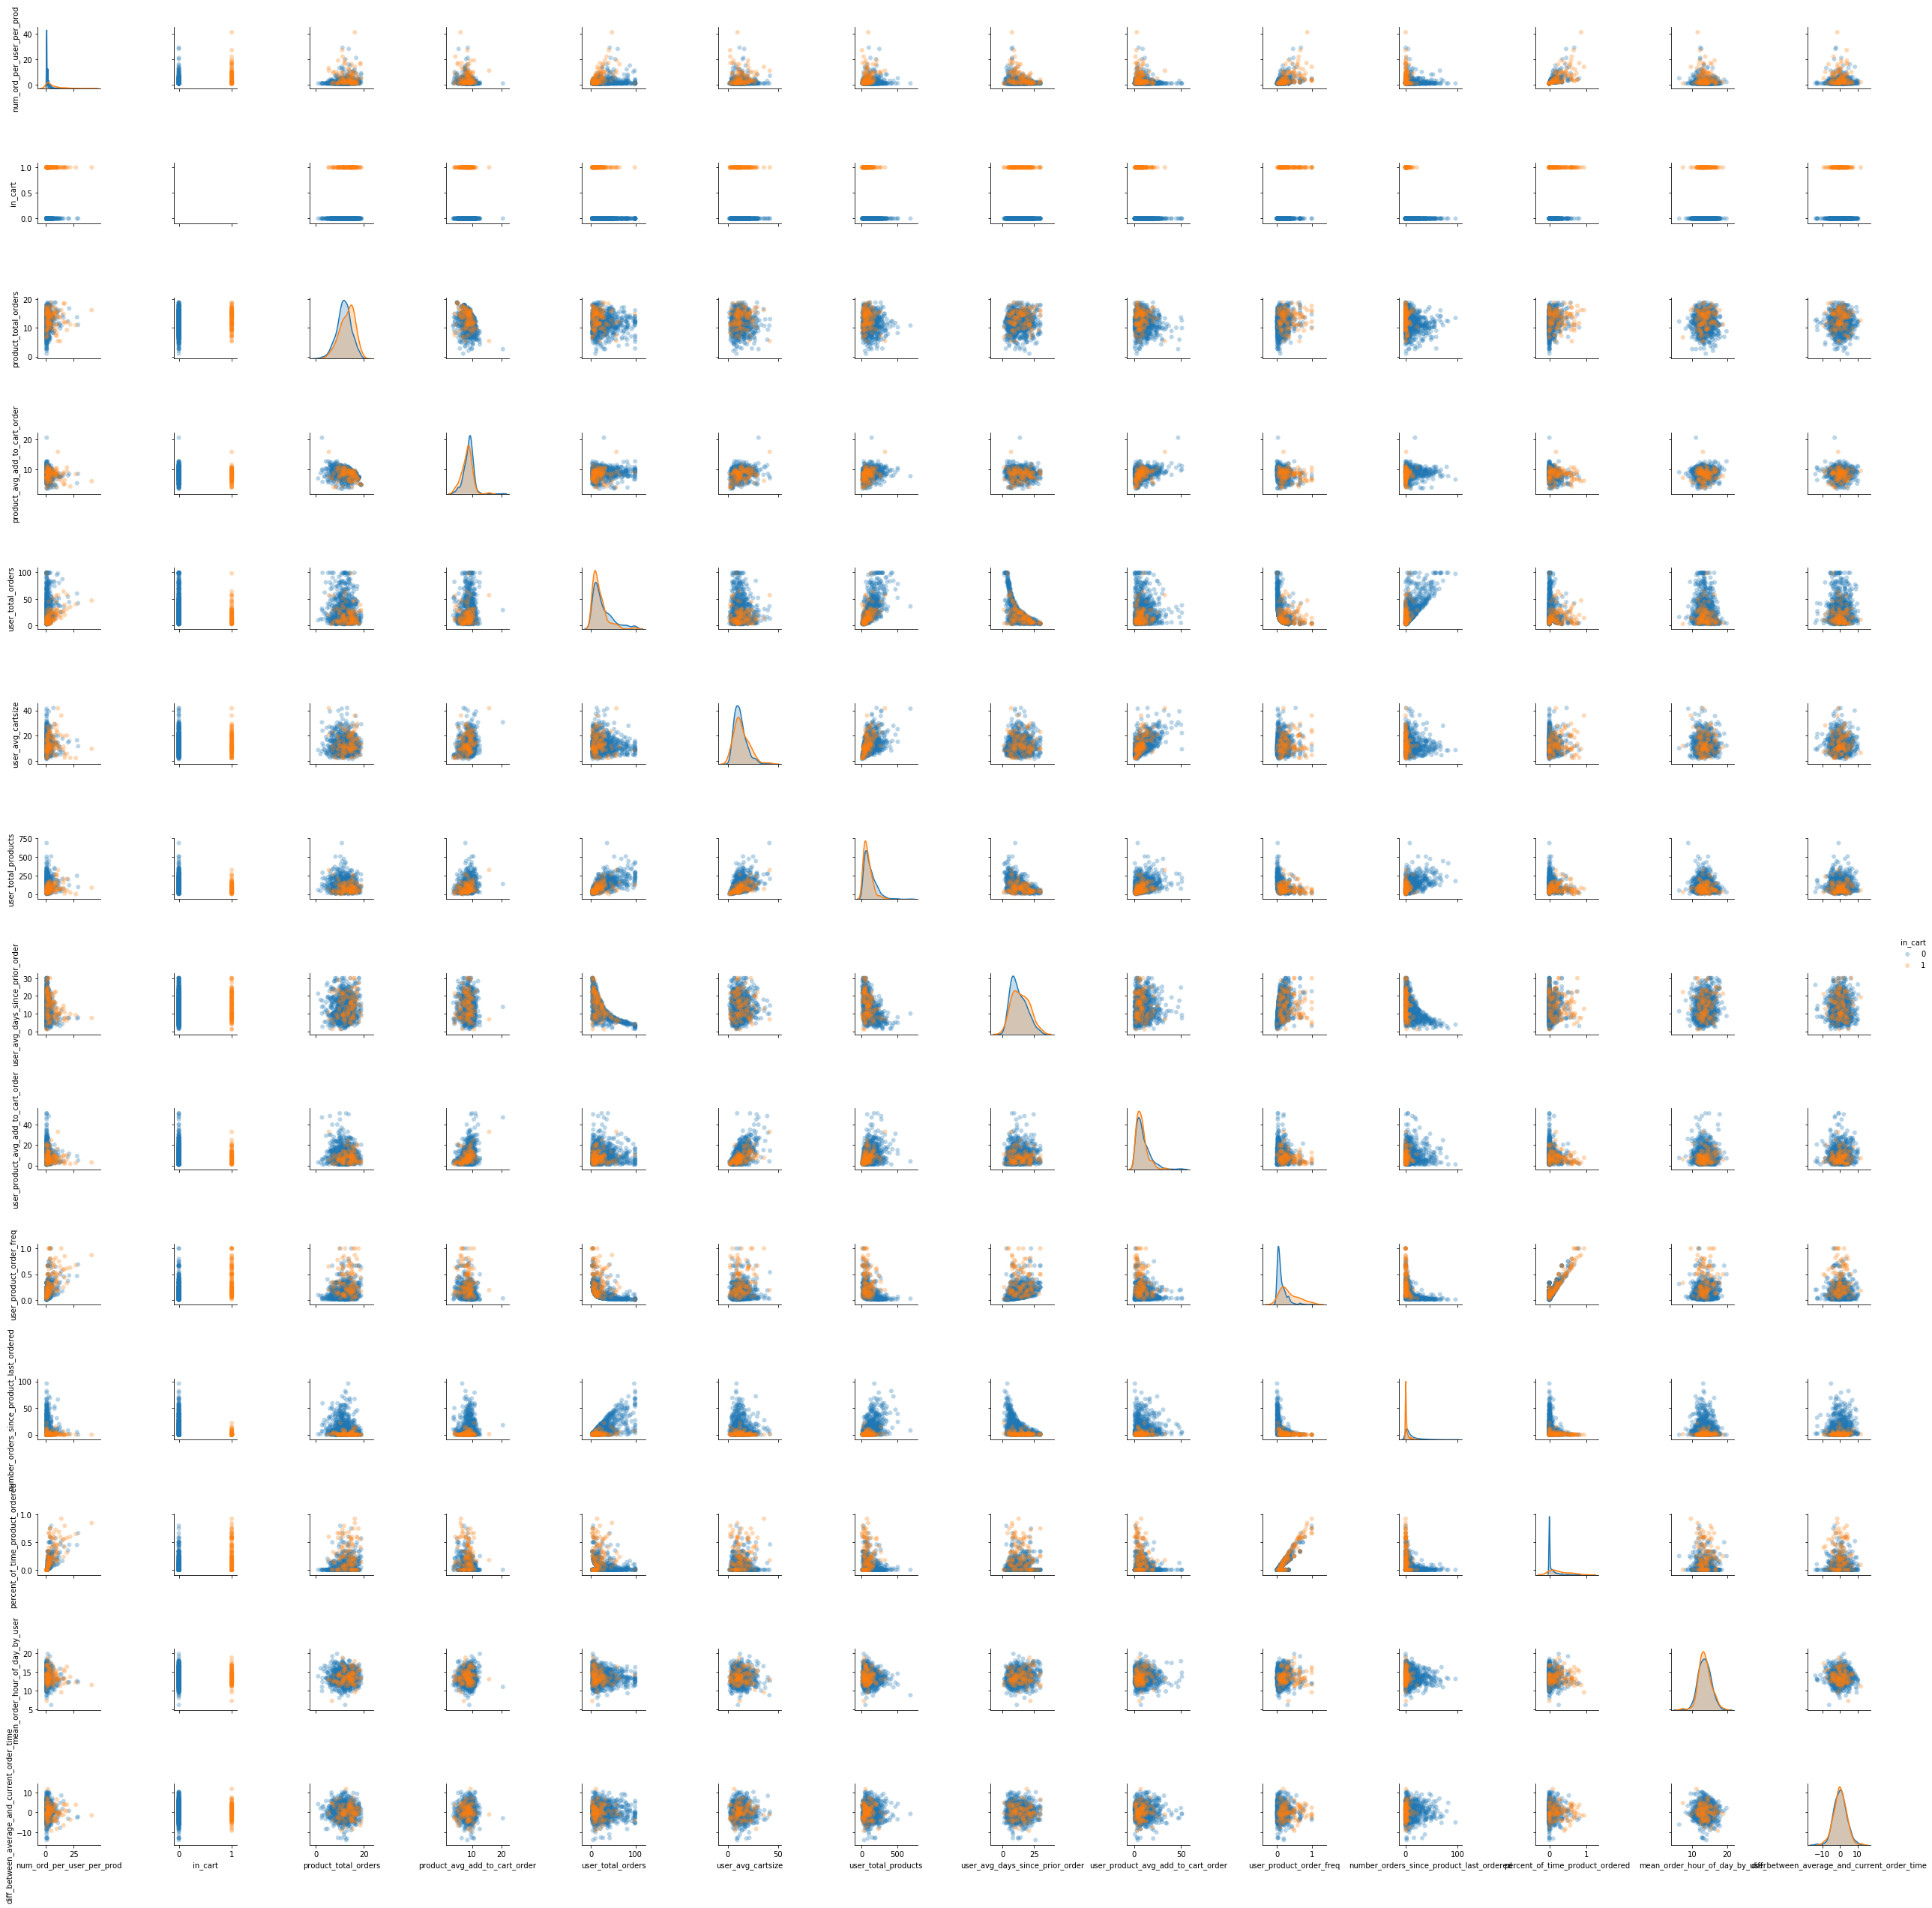

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Our f1-score is 0.24290178741567897
The coefficients are: 
                                        Features  Coefficients
0                     num_ord_per_user_per_prod        0.0135
1                          product_total_orders        0.0237
2                 product_avg_add_to_cart_order       -0.1322
3                             user_total_orders        0.0086
4                             user_avg_cartsize        0.0267
5                           user_total_products       -0.0015
6               user_avg_days_since_prior_order       -0.0056
7            user_product_avg_add_to_cart_order       -0.0037
8                       user_product_order_freq        1.5811
9      number_orders_since_product_last_ordered       -0.1196
10              percent_of_time_product_ordered        2.0241
11               mean_order_hour_of_day_by_user       -0.0396
12  diff_between_average_and_current_order_time        0.0051
And we've predicted 1653075 non-re-orders and 42659 re-orders.


In [21]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## Weighting products for more of more recent orders

In [22]:
recent_order_weight = ord_prod_train_df.loc[:,['product_id', 'reordered', 'user_id', 'order_number']]
max_order_number = ord_df.groupby(['user_id'],as_index=False).agg({'order_number':'max'})
max_order_number.columns = ['user_id','max_order_number']
recent_order_weight = recent_order_weight.merge(max_order_number,on='user_id')
# Here we set max_order_number to be the nth traingular number of the max order number
recent_order_weight['max_order_number'] = ((recent_order_weight.max_order_number *
                                            (recent_order_weight.max_order_number + 1)) / 2)
recent_order_weight['recent_order_weight'] = ((recent_order_weight.reordered 
                                              * recent_order_weight.order_number)
                                              / recent_order_weight.max_order_number)
recent_order_weight = recent_order_weight.groupby(['product_id','user_id'],as_index=False).sum()
recent_order_weight.drop(['reordered','order_number'],axis=1,inplace=True)
df = pd.merge(df, recent_order_weight,on=['user_id','product_id'])

<Figure size 648x648 with 0 Axes>

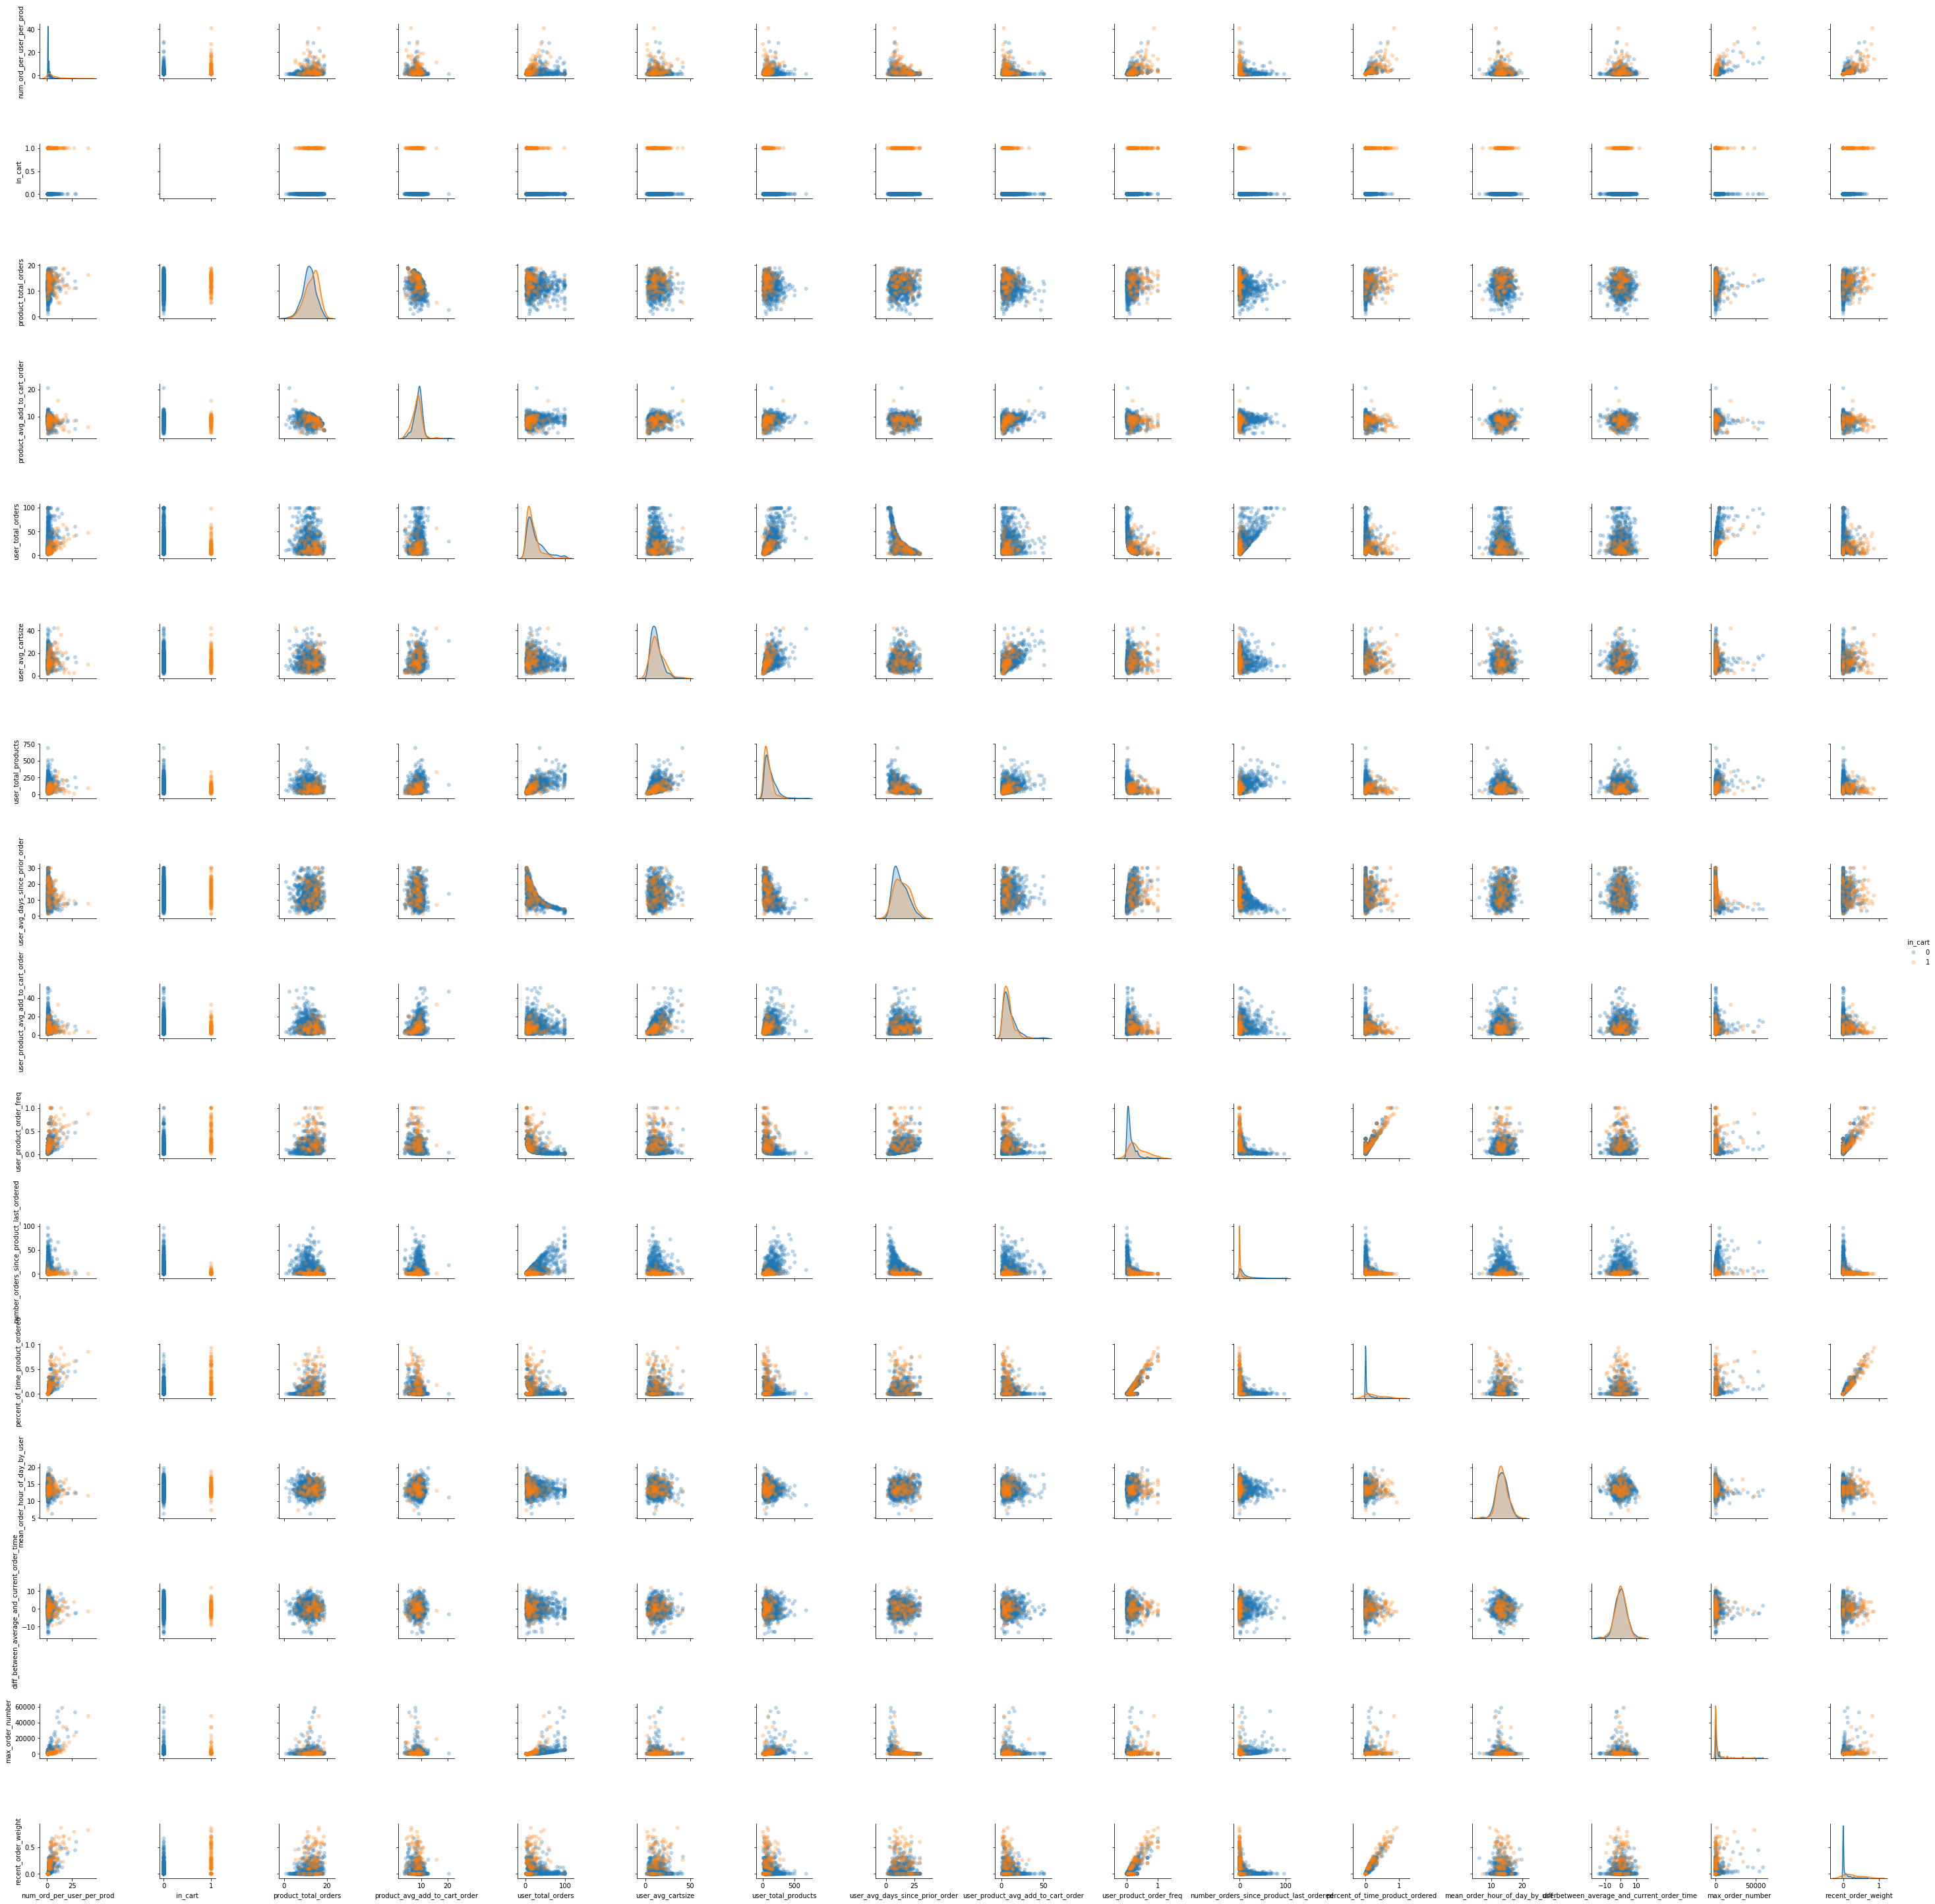

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Our f1-score is 0.14633151747717982
The coefficients are: 
                                        Features  Coefficients
0                     num_ord_per_user_per_prod        0.1499
1                          product_total_orders        0.0192
2                 product_avg_add_to_cart_order       -0.1228
3                             user_total_orders        0.0084
4                             user_avg_cartsize        0.0470
5                           user_total_products       -0.0053
6               user_avg_days_since_prior_order       -0.0039
7            user_product_avg_add_to_cart_order       -0.0140
8                       user_product_order_freq        0.0135
9      number_orders_since_product_last_ordered       -0.1587
10              percent_of_time_product_ordered        0.0148
11               mean_order_hour_of_day_by_user       -0.0881
12  diff_between_average_and_current_order_time       -0.0081
13                             max_order_number       -0.0000
14        

In [23]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

### Removing Max Order Number
Max order number clearly had a significant negative impact and has been removed.

In [ ]:
df.drop(['max_order_number'],axis=1,inplace=True)

In [ ]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## Adding Department Dummy Variable

In [24]:
department_name_product_id = (prod_df.merge(dep_df,on='department_id')
                              .drop(['product_name','aisle_id','department_id'],axis=1))
dep_dummies = pd.get_dummies(department_name_product_id,drop_first=False)
dummies_cols = dep_dummies.columns.tolist()
new_cols = []
for name in dummies_cols:
    new_cols.append(str.replace(name,' ','_'))
dep_dummies.columns = new_cols

dep_dummies['positvely_corr_departments'] = dep_dummies.department_dairy_eggs + dep_dummies.department_produce
dep_dummies['negatively_corr_departments'] = dep_dummies.department_pantry + dep_dummies.department_personal_care
dep_dummies = dep_dummies[['negatively_corr_departments','positvely_corr_departments','product_id']]

df = pd.merge(df, dep_dummies,on=['product_id'])

<Figure size 648x648 with 0 Axes>

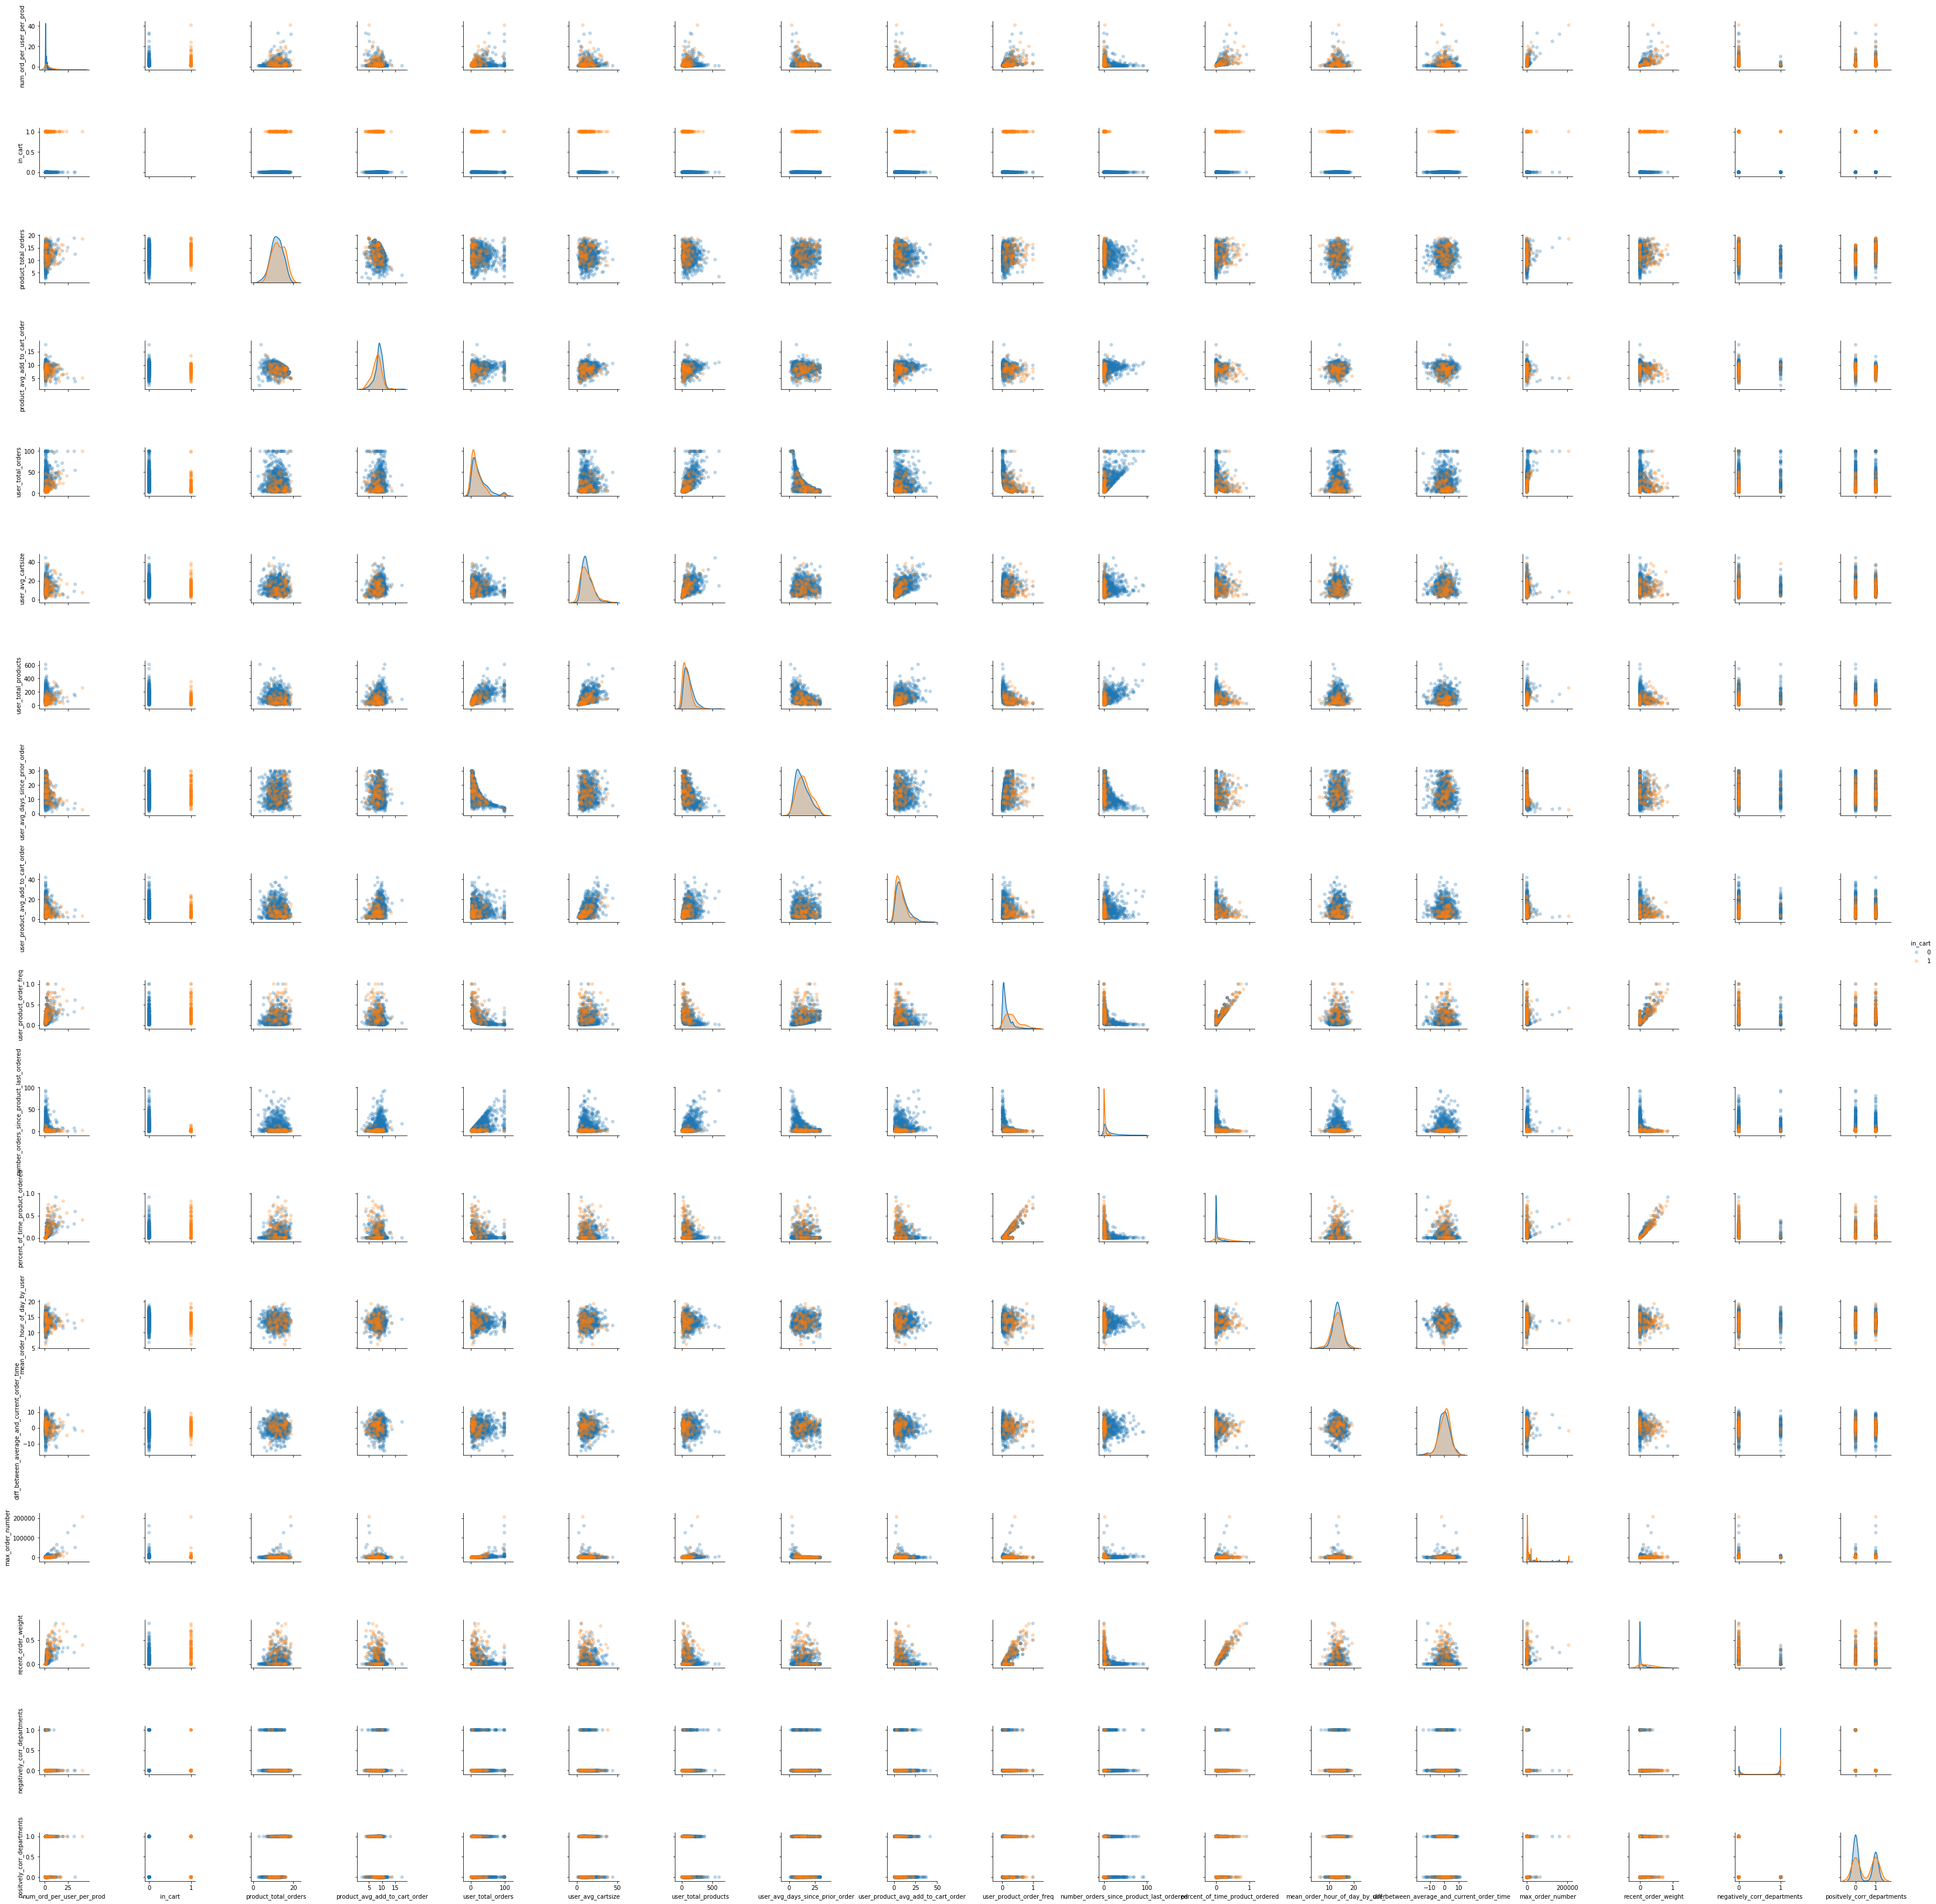

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Our f1-score is 0.14640241320361144
The coefficients are: 
                                        Features  Coefficients
0                     num_ord_per_user_per_prod        0.1498
1                          product_total_orders        0.0186
2                 product_avg_add_to_cart_order       -0.1225
3                             user_total_orders        0.0084
4                             user_avg_cartsize        0.0472
5                           user_total_products       -0.0053
6               user_avg_days_since_prior_order       -0.0038
7            user_product_avg_add_to_cart_order       -0.0138
8                       user_product_order_freq        0.0135
9      number_orders_since_product_last_ordered       -0.1588
10              percent_of_time_product_ordered        0.0148
11               mean_order_hour_of_day_by_user       -0.0881
12  diff_between_average_and_current_order_time       -0.0080
13                             max_order_number       -0.0000
14        

In [25]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

In [28]:
pd.to_pickle(df,'full_features_with_dep')